In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn

In [41]:
df_desc = pd.read_csv('feature_desc.csv')
df = pd.read_csv('all_training.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1736 non-null   object 
 1   Sex         1736 non-null   float64
 2   Age         1682 non-null   float64
 3   CA          1643 non-null   float64
 4   CK          704 non-null    float64
 5   CREA        1662 non-null   float64
 6   ALP         1262 non-null   float64
 7   GGT         1300 non-null   float64
 8   GLU         1638 non-null   float64
 9   AST         1638 non-null   float64
 10  ALT         1640 non-null   float64
 11  LDH         1433 non-null   float64
 12  PCR         1639 non-null   float64
 13  KAL         1656 non-null   float64
 14  NAT         1663 non-null   float64
 15  UREA        1060 non-null   float64
 16  WBC         1673 non-null   float64
 17  RBC         1673 non-null   float64
 18  HGB         1673 non-null   float64
 19  HCT         1673 non-null  

In [42]:
# Take only CBC columns
cbc_columns = list(df_desc.loc[df_desc['CBC features']==1]['Acronym'])
cbc_columns = [c for c in cbc_columns if c not in['MPV', 'RDW']]
print(f'CBC columns:\n{cbc_columns}\n')

df_cbc = df[cbc_columns]
print(f'Removed values: {len(df)} - {len(df_cbc)} = {len(df)-len(df_cbc)}')

bin_cols = ['Sex', 'Suspect', 'target']

for col in cbc_columns:
    if col not in bin_cols:
        df_cbc[col] = df_cbc[col].fillna(df[col].mean())
    else:
        df_cbc[col] = df_cbc[col].astype(int)

CBC columns:
['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT', 'NE', 'LY', 'MO', 'EO', 'BA', 'NET', 'LYT', 'MOT', 'EOT', 'BAT', 'Age', 'Sex', 'Suspect', 'target']

Removed values: 1736 - 1736 = 0


ipykernel_launcher:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


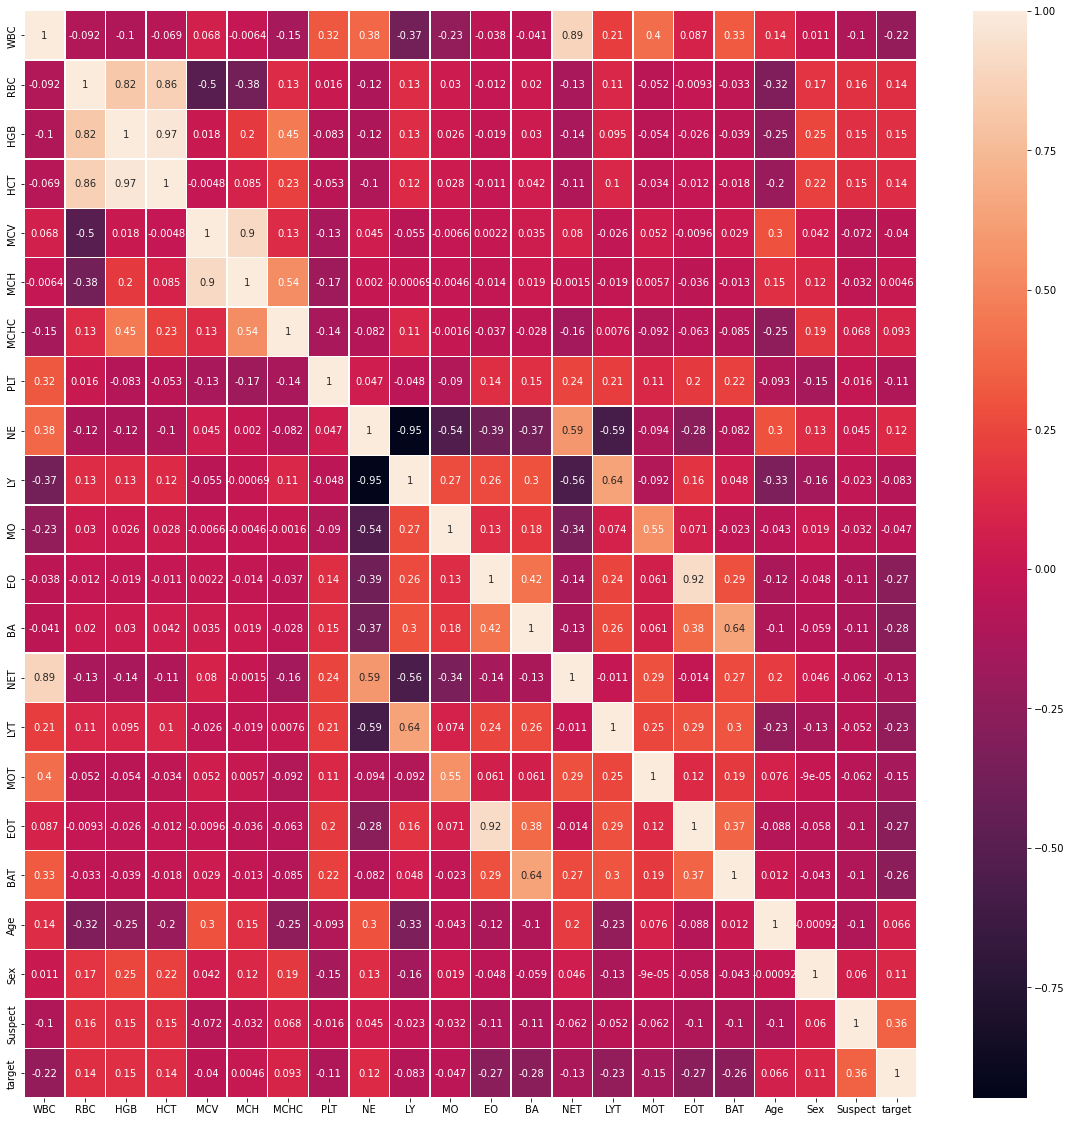

In [43]:
fig, ax = plt.subplots(figsize=(20,20))  
sn.heatmap(df_cbc.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

In [44]:
cbc_cols_del = ['NET', 'RBC', 'HCT', 'MCH', 'NE', 'EO', 'LY', 'BAT']
df_cbc = df_cbc.drop(cbc_cols_del, axis=1)

c = df_cbc.corr().abs()
s = c.unstack()
s = s[s>0.4]
s = s[s<1]
so = s.sort_values(kind="quicksort")
print(s)

WBC   MOT     0.401276
HGB   MCHC    0.453098
MCHC  HGB     0.453098
MO    MOT     0.551393
MOT   WBC     0.401276
      MO      0.551393
dtype: float64


In [45]:
X = np.array(df_cbc.copy().drop('target', axis=1))
y = np.array(df_cbc['target'])

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Simple neural network

In [47]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10),
#         # )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# XGBoost

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.12,
                max_depth = 4, alpha = 11, n_estimators = 8)

xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test) > 0.5
acc = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'Accuracy: {acc}')
print(f'Specificity: {tn / (tn+fp)}')
print(f'Sensitivity: {tp / (tp+fn)}')


[19:07:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7729885057471264
Specificity: 0.8043478260869565
Sensitivity: 0.7378048780487805


# ANN

In [93]:
import tensorflow as tf

input = tf.keras.layers.Input(shape=(13,))
x = tf.keras.layers.Dense(20, activation='relu', kernel_initializer='glorot_uniform')(input)
x = tf.keras.layers.Dense(40, activation='relu', kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Dense(80, activation='relu', kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
model = tf.keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Train on 1388 samples
Epoch 1/10
1388/1388 [==============================] - 0s 240us/sample - loss: 0.7015 - accuracy: 0.4892
Epoch 2/10
1388/1388 [==============================] - 0s 77us/sample - loss: 0.6940 - accuracy: 0.4690
Epoch 3/10
1388/1388 [==============================] - 0s 76us/sample - loss: 0.6932 - accuracy: 0.4705
Epoch 4/10
1388/1388 [==============================] - 0s 77us/sample - loss: 0.6931 - accuracy: 0.4705
Epoch 5/10
1388/1388 [==============================] - 0s 76us/sample - loss: 0.6931 - accuracy: 0.4705
Epoch 6/10
1388/1388 [==============================] - 0s 84us/sample - loss: 0.6931 - accuracy: 0.4705
Epoch 7/10
1388/1388 [==============================] - 0s 77us/sample - loss: 0.6932 - accuracy: 0.4705
Epoch 8/10
1388/1388 [==============================] - 0s 76us/sample - loss: 0.6931 - accuracy: 0.4705
Epoch 9/10
1388/1388 [==============================] - 0s 76us/sample - loss: 0.6931 - accuracy: 0.4705
Epoch 10/10
1388/1388 [=========

# CatBoost

In [49]:
from catboost import CatBoostClassifier
# TODO: FIX IT OR DISCARD
X = df_cbc.copy().drop('target', axis=1)
y = df_cbc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

CAT_FEATURES = [11, 12]
print(list(X_train))
# set up the model
catboost_model = CatBoostClassifier()
# fit model
catboost_model.fit(X_train, y_train, 
                   eval_set = (X_test, y_test),
                   cat_features=CAT_FEATURES,
                   use_best_model = True)
X_pred = catboost_model.predict(X_test) > 0.5
acc = accuracy_score(y_test, y_pred)
print(acc)


['WBC', 'HGB', 'MCV', 'MCHC', 'PLT', 'MO', 'BA', 'LYT', 'MOT', 'EOT', 'Age', 'Sex', 'Suspect']
Learning rate set to 0.034362
0:	learn: 0.6792871	test: 0.6796166	best: 0.6796166 (0)	total: 2.05ms	remaining: 2.05s
1:	learn: 0.6629531	test: 0.6653911	best: 0.6653911 (1)	total: 4.04ms	remaining: 2.02s
2:	learn: 0.6497647	test: 0.6542417	best: 0.6542417 (2)	total: 5.95ms	remaining: 1.98s
3:	learn: 0.6364017	test: 0.6430783	best: 0.6430783 (3)	total: 7.67ms	remaining: 1.91s
4:	learn: 0.6249904	test: 0.6331725	best: 0.6331725 (4)	total: 9.4ms	remaining: 1.87s
5:	learn: 0.6128630	test: 0.6232123	best: 0.6232123 (5)	total: 11ms	remaining: 1.82s
6:	learn: 0.6032870	test: 0.6151956	best: 0.6151956 (6)	total: 12.4ms	remaining: 1.76s
7:	learn: 0.5928019	test: 0.6066559	best: 0.6066559 (7)	total: 13.9ms	remaining: 1.72s
8:	learn: 0.5839674	test: 0.5996677	best: 0.5996677 (8)	total: 15.3ms	remaining: 1.68s
9:	learn: 0.5761120	test: 0.5941034	best: 0.5941034 (9)	total: 16.7ms	remaining: 1.66s
10:	lear

# NODE

In [50]:
import lib
import math
import time
import torch, torch.nn as nn
import torch.nn.functional as F
from qhoptim.pyt import QHAdam
from category_encoders import LeaveOneOutEncoder
X = df_cbc.copy().drop('target', axis=1)
y = df_cbc['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
class_to_int = {c: i for i, c in enumerate(y_train.unique())}                                                                                                               
y_train_int = [class_to_int[v] for v in y_train]                                                                                                                            
y_val_int = [class_to_int[v] for v in y_val] 

cat_features = ['Sex', 'Suspect']
cat_encoder = LeaveOneOutEncoder()
cat_encoder.fit(X_train[cat_features], y_train_int)
X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
X_val[cat_features] = cat_encoder.transform(X_val[cat_features])

X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
y_train = np.array(y_train_int)
y_val = np.array(y_val_int)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = X_train.shape[1]
num_classes = len(set(y_train))
ts = math.floor(time.time())
experiment_name = f'node_adult_{ts}'
model = nn.Sequential(
    lib.DenseBlock(num_features,
                   layer_dim=128,
                   num_layers=3,
                   tree_dim=num_classes,
                   flatten_output=False,
                   depth=6,
                   choice_function=lib.entmax15,
                   bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(X_train[:2000], device=device))

/home/bk/cbc/venv/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
)
loss_history, err_history = [], []
best_val_err = 1.0
best_step = 0
early_stopping_rounds = 2500
report_frequency = 1000

/home/bk/cbc/venv/lib/python3.6/site-packages/qhoptim/pyt/qhadam.py:133: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1_adj).add_(1.0 - beta1_adj, d_p)


Saved logs/node_adult_1634231229/checkpoint_temp_1000.pth
Loaded logs/node_adult_1634231229/checkpoint_avg.pth
Saved logs/node_adult_1634231229/checkpoint_best.pth
Loaded logs/node_adult_1634231229/checkpoint_temp_1000.pth


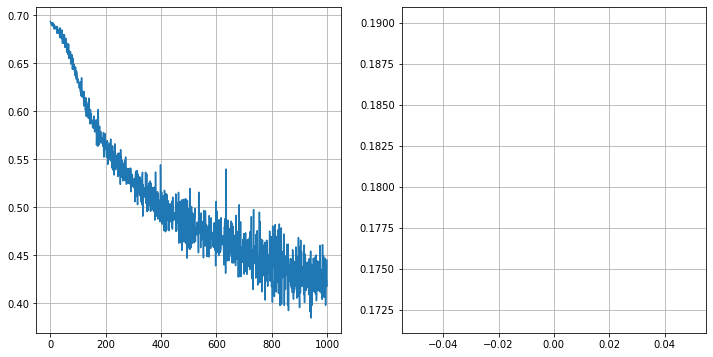

Loss 0.44475
Val Error Rate: 0.18103
Saved logs/node_adult_1634231229/checkpoint_temp_2000.pth
Loaded logs/node_adult_1634231229/checkpoint_avg.pth
Loaded logs/node_adult_1634231229/checkpoint_temp_2000.pth


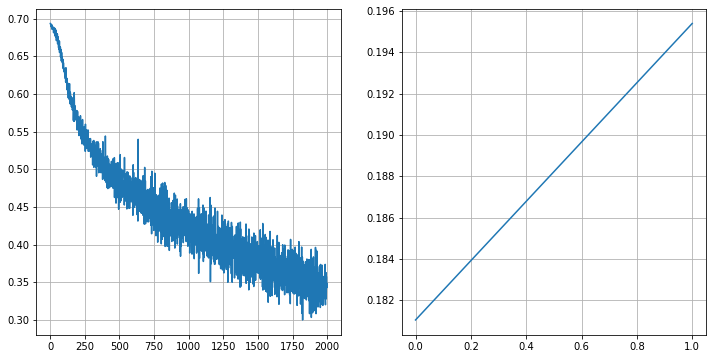

Loss 0.34834
Val Error Rate: 0.19540
Saved logs/node_adult_1634231229/checkpoint_temp_3000.pth
Loaded logs/node_adult_1634231229/checkpoint_avg.pth
Loaded logs/node_adult_1634231229/checkpoint_temp_3000.pth


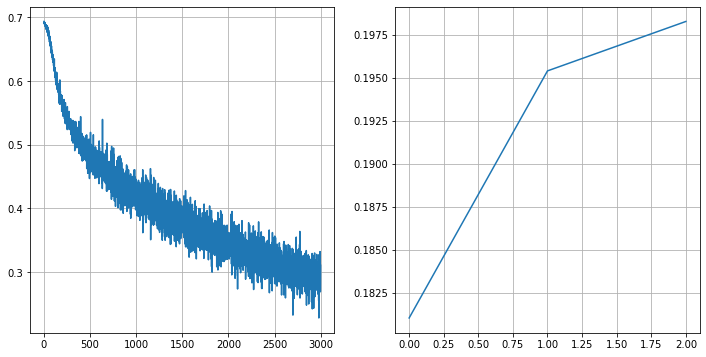

Loss 0.31070
Val Error Rate: 0.19828
BREAK. There is no improvement for 2500 steps
Best step:  1000
Best Val Error Rate: 0.18103


In [52]:
for batch in lib.iterate_minibatches(X_train,
                                     y_train,
                                     batch_size=512, 
                                     shuffle=True,
                                     epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        err = trainer.evaluate_classification_error(
            X_val,
            y_val,
            device=device,
            batch_size=128)
        
        if err < best_val_err:
            best_val_err = err
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(err)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
            
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvement for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error Rate: %0.5f" % (best_val_err))
        break

In [74]:
X_val_tensor = torch.from_numpy(X_val).to(device)
y_pred = list(torch.sigmoid(model(X_val_tensor)).cpu().detach().numpy())

y_pred = [0 if x[0] > x[1] else 1 for x in y_pred ]

acc = accuracy_score(y_val_int, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'Accuracy: {acc}')
print(f'Specificity: {tn / (tn+fp)}')
print(f'Sensitivity: {tp / (tp+fn)}')

Accuracy: 0.8074712643678161
Specificity: 0.40217391304347827
Sensitivity: 0.573170731707317


In [ ]:
X_val_tensor = torch.from_numpy(X_val).to(device)
y_pred = list(torch.sigmoid(model(X_val_tensor)).cpu().detach().numpy())

y_pred = [0 if x[0] > x[1] else 1 for x in y_pred ]

acc = accuracy_score(y_val_int, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'Accuracy: {acc}')
print(f'Specificity: {tn / (tn+fp)}')
print(f'Sensitivity: {tp / (tp+fn)}')

In [75]:
from hyperopt import fmin, hp, STATUS_OK, tpe

def opt_fn(search_space):
  print(search_space)
  best_val_err = 1.0
  best_step = 0
  early_stopping_rounds = 2500
  report_frequency = 1000
  experiment_name = 'debug' # this bypasses some code that will be executed each time otherwise
  
  model = nn.Sequential(
      lib.DenseBlock(num_features,
                     layer_dim=int(search_space['layer_dim']),
                     num_layers=int(search_space['num_layers']),
                     tree_dim=num_classes,
                     flatten_output=False,
                     depth=int(search_space['depth']),
                     choice_function=lib.entmax15,
                     bin_function=lib.entmoid15),
      lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
    ).to(device)

  with torch.no_grad():
    res = model(torch.as_tensor(X_train[:2000], device=device))
    # trigger data-aware init

  trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
  )

  for batch in lib.iterate_minibatches(X_train,
                                     y_train,
                                     batch_size=512, 
                                     shuffle=True,
                                     epochs=float('inf')):
    
    metrics = trainer.train_on_batch(*batch, device=device)
    

    if trainer.step % report_frequency == 0:
          err = trainer.evaluate_classification_error(
              X_val,
              y_val,
              device=device,
              batch_size=64)
        
          if err < best_val_err:
              best_val_err = err
              best_step = trainer.step

          print("Loss %.5f" % (metrics['loss']))
          print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
          opt_metric = best_val_err
          break
          
  return {'loss': opt_metric, 'status': STATUS_OK}

In [76]:
search_space = {'layer_dim': hp.quniform('layer_dim', 100, 1200, 100),
                'num_layers': hp.quniform('num_layers', 1, 4, 1),
                'depth': hp.quniform('depth', 2, 7, 1)
    }

best = fmin(fn=opt_fn, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=100)

{'depth': 6.0, 'layer_dim': 600.0, 'num_layers': 2.0}
Loss 0.48873
Val Error Rate: 0.19540
Loss 0.43608
Val Error Rate: 0.18678
Loss 0.35317
Val Error Rate: 0.21552
Loss 0.33598
Val Error Rate: 0.19828
{'depth': 4.0, 'layer_dim': 400.0, 'num_layers': 2.0}
Loss 0.52249
Val Error Rate: 0.20115
  1%|          | 1/100 [05:26<8:58:37, 326.44s/trial, best loss: 0.1867816091954023]


KeyboardInterrupt: 

# TabNet

In [ ]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
clf = TabNetMultiTaskClassifier()
clf.fit(
  X_train, Y_train,
  eval_set=[(X_valid, y_valid)]
)
preds = clf.predict(X_test)

# DFN-Net

# 1D-CNN

# SNN

# GrowNet

# DCN V2

# AutoInt